In [1]:
import pandas as pd
import os
import numpy as np

def read_data(data_file):
    data_structure = pd.read_csv(os.path.join('data',data_file))
    return data_structure

features = read_data('dengue_features_train.csv');
labels = read_data('dengue_labels_train.csv');
print('Training data readed!')

# We mix features and labels in a single dataset for commodity
features['total_cases']=labels['total_cases']

Training data readed!


In [2]:
# Number of cities
features.city.unique()
# We split data for the two cities
city_data = features[features['city'] == 'iq']


We observe that the magnitude of features is the most relevant factor in the matrix. That is, we need to scale data before we start looking for correlations.

# Data imputation
We check out how many of the features are missing columnwise

In [3]:
missing = {}
for col in city_data:
    missing_no = city_data[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;

We observe that some of these could be estimated using alternative features. That is hte example of "station_avg_temp_c", which could be estimated using "station_max_temp_c" and "station_min_temp_c" if they existed. Same could happen with "reanalysis_avg_temp_k".

We start interpolating the missing values

In [4]:
for col in missing.keys():
    city_data[col].interpolate(inplace=True)

/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/pandas/core/generic.py:7070: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# New features

In [5]:
city_data['USER_month'] = city_data.apply(lambda x: int(x['week_start_date'][5:7]), axis=1);
city_data['USER_day'] = city_data.apply(lambda x: int(x['week_start_date'][8:10]), axis=1);
city_data.pop('week_start_date');
city_data.pop('city');

/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
# We define the four seasons from the North hemishpere. 
def season(input_data):
    input_data = int(input_data)
    if (input_data >=1) & (input_data <=3): # Winter        
        output = 4;        
    if (input_data >=4) & (input_data <=6): # Spring        
        output = 1;
    if (input_data >=7) & (input_data <=9): # Summer        
        output = 2;
    if (input_data >=10) & (input_data <=12): # Autumn/Fall        
        output = 3;
    return output

city_data['USER_season'] = city_data['USER_month'].apply(season);
city_data['total_cases_LOG'] = np.log(city_data['total_cases'])
city_data['total_cases_LOG'][city_data['total_cases_LOG'] <0 ] =0
# city_data['total_cases_EMA'] = np.log(city_data['total_cases'].ewm(alpha=.5).mean())
city_data['USER_season'][5]


/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from 

KeyError: 5

In [7]:
def context_extractor(data_structure):
    alt_data_structure = data_structure[:];
    
    col_names = [i for i in data_structure.columns  if i not in ['total_cases','total_cases_LOG','diff','pos_neg']]
    lag = 1;
    col_names_lag = [i+'_'+str(lag) for i in col_names]
    
    alt_data_structure[col_names_lag] = city_data[col_names]
    alt_data_structure['weekofyear_1'] = alt_data_structure['weekofyear_1'].shift(1)
#     for i in range(len(data_structure)):
#         if i > 0:
#             print(alt_data_structure['weekofyear_1'].iloc[i], city_data['weekofyear'].iloc[i-1])
#             alt_data_structure[col_names_lag].iloc[i] = city_data[col_names].iloc[i-1].values
#             print(alt_data_structure['weekofyear_1'].iloc[i], city_data['weekofyear'].iloc[i-1])
#             break
            
    return alt_data_structure
# city_data= context_extractor(city_data)
# city_data.fillna(0, inplace=True)

In [8]:
# aux = city_data['total_cases'].ewm(alpha=.1).mean().diff()
# aux.iloc[0] = 0
# city_data['diff'] = aux;
# city_data['pos_neg'] = (aux>=0)*1.0+(aux<0)*(-1.0);


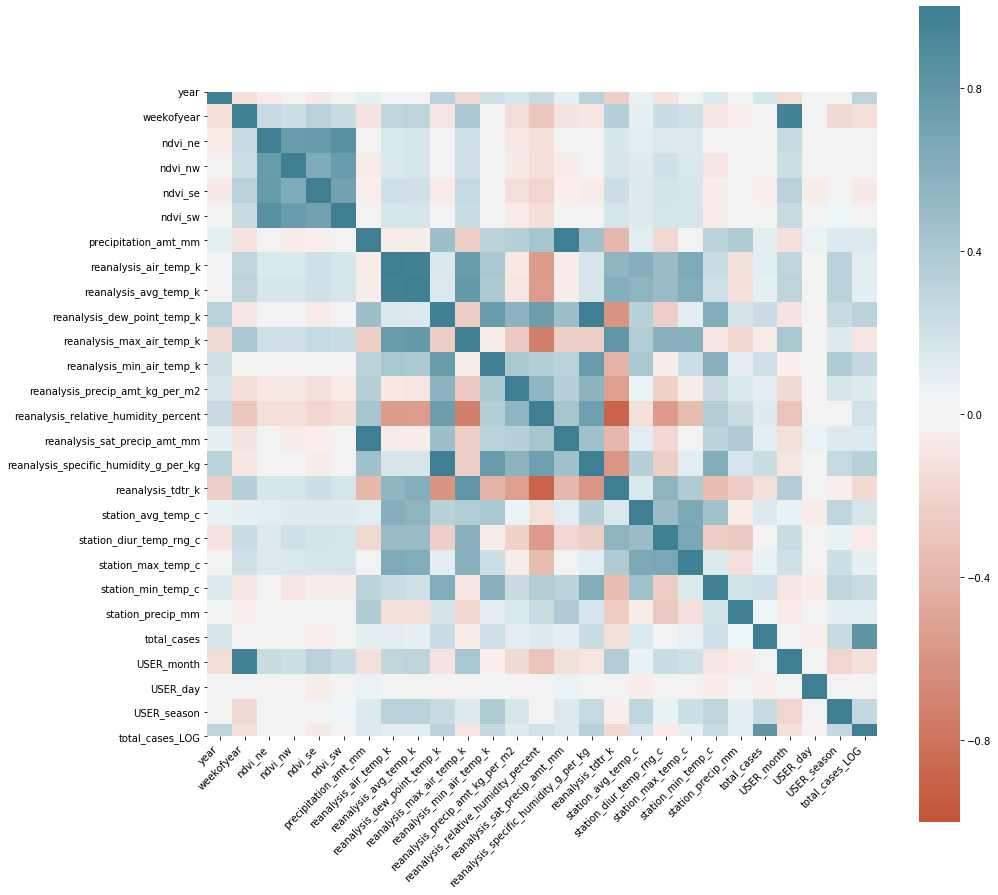

In [10]:
# We study each feature independently and how it relates with the rest
correlation = city_data.corr()
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,15)) 
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [13]:

# # plt.subplot(211)
# # plt.plot(np.log(city_data['total_cases']))


# plt.subplot(211)
# plt.plot(city_data['total_cases'])
# plt.subplot(212)
# # plt.plot((city_data['total_cases_LOG']))
# plt.plot([city_data['total_cases'].autocorr(i) for i in range(150) ])


In [40]:
i_test = int(np.round(len(x_train.index))*.9); # 10 per cent used for test in any dataset
x_train = city_data[[col for col in city_data.columns if col not in ['total_cases','total_cases_LOG','diff','pos_neg']]]
y_train = city_data['total_cases_LOG']
x_test = x_train.iloc[i_test:]
y_test = y_train[i_test:].values
x_train = x_train.iloc[:i_test]
y_train = y_train[:i_test].values

from ML_utils.Regressors import Regressors
n_splits = 5

In [29]:

# x_train.index


468

In [ ]:
reg_list = ['RandomForest','KNN','AdaBoost','BayesianRidge','KernelRidge','LinearRegression','GradientBoosting','MLP'];#['RandomForest','KNN','GradientBoosting','AdaBoost','BayesianRidge','KernelRidge','LinearRegression'];
model = {};
model_scores = {};
for model_name in reg_list:
    # Random Forest
    model[model_name] = Regressors()
    model[model_name].get_regressor(model_name)
    model[model_name].get_TimeSeries_CV(score='neg_mean_absolute_error',n_splits = n_splits)
    model[model_name].fit_model(x_train, y_train)

    y_pred_train = model[model_name].return_prediction(x_train)
    y_pred_test  = model[model_name].return_prediction(x_test)

    from sklearn.metrics import mean_absolute_error
    model_scores[model_name] = model[model_name].plot_results(np.exp(y_test), np.exp(y_pred_test), mean_absolute_error)
    plt.title(model_name);
    


Score: 6.478820577010249
Score: 7.47823291541649
Score: 6.605143772998174
Score: 7.078494018211816
Score: 6.661647911642365
Score: 7.440387371504076


/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

5.1384780586211996

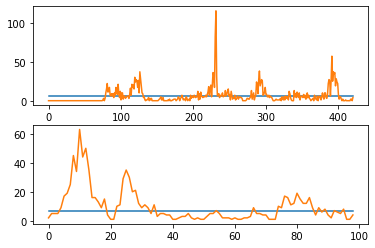

In [42]:
# # Meta Regressor
# from sklearn.neural_network import MLPRegressor
# x_train_meta = x_train[:]#pd.DataFrame()
# x_test_meta = x_test[:];#pd.DataFrame()
# for model_name in model.keys():
#     x_train_meta[model_name] = np.exp(model[model_name].return_prediction(x_train));
#     x_test_meta[model_name] = np.exp(model[model_name].return_prediction(x_test));

# meta = Regressors()
# meta.get_regressor('MLP')
# meta.get_TimeSeries_CV(score='neg_mean_absolute_error',n_splits = n_splits)
# meta.fit_model(x_train_meta, np.exp(y_train))

# y_pred_train = meta.return_prediction(x_train_meta)
# y_pred_test  = meta.return_prediction(x_test_meta)

# plt.subplot(211)
# plt.plot(y_pred_train)
# plt.plot(np.exp(y_train))
# plt.subplot(212)
# plt.plot(y_pred_test)
# plt.plot(np.exp(y_test))
# mean_absolute_error(y_test, y_pred_test)

In [ ]:
y_pred_train = np.zeros_like(y_train)
y_pred_test = np.zeros_like(y_test)
for model_name in reg_list:
    y_pred_train += np.exp(model[model_name].return_prediction(x_train))
    y_pred_test  += np.exp(model[model_name].return_prediction(x_test))

y_pred_train /= len(reg_list);
y_pred_test /= len(reg_list);
print('Train error: {}'.format(mean_absolute_error(np.exp(y_train), (y_pred_train))))
print('Test error: {}'.format(mean_absolute_error(np.exp(y_test), (y_pred_test))))

plt.subplot(211)
plt.plot(np.exp(y_pred_train))
plt.plot(np.exp(y_train))
plt.subplot(212)
plt.plot(np.exp(y_pred_test))
plt.plot(np.exp(y_test))


Train error: 4.811805420234701
Test error: 6.571277147960088


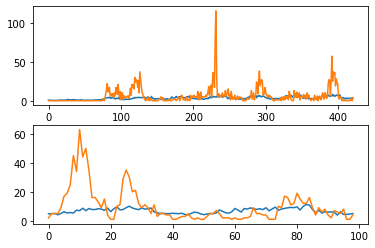

In [54]:
y_pred_train = np.zeros_like(y_train)
y_pred_test = np.zeros_like(y_test)
for model_name in reg_list:
    y_pred_train += model[model_name].return_prediction(x_train)
    y_pred_test  += model[model_name].return_prediction(x_test)

y_pred_train /= len(reg_list);
y_pred_test /= len(reg_list);
print('Train error: {}'.format(mean_absolute_error(np.exp(y_train), np.exp(y_pred_train))))
print('Test error: {}'.format(mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))))

plt.subplot(211)
plt.plot(np.exp(y_pred_train))
plt.plot(np.exp(y_train))
plt.subplot(212)
plt.plot(np.exp(y_pred_test))
plt.plot(np.exp(y_test))


# Test data

In [64]:
x_test_real = pd.read_csv('data/dengue_features_test.csv')
missing = {}
for col in x_test_real:
    missing_no = x_test_real[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;
        
for col in missing.keys():
    x_test_real[col].interpolate(inplace=True)

x_test_real['USER_month'] = x_test_real.apply(lambda x: int(x['week_start_date'][5:7]), axis=1);
x_test_real['USER_day'] = x_test_real.apply(lambda x: int(x['week_start_date'][8:10]), axis=1);
x_test_real.pop('week_start_date');
x_test_real['USER_season'] = x_test_real['USER_month'].apply(season);

/run/media/arodriguez/BIG/anaconda2/envs/deep_py3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
model

{'RandomForest': <ML_utils.Regressors.Regressors at 0x7f95c4d43ba8>,
 'KNN': <ML_utils.Regressors.Regressors at 0x7f95a188f898>,
 'AdaBoost': <ML_utils.Regressors.Regressors at 0x7f95c4d3b828>,
 'BayesianRidge': <ML_utils.Regressors.Regressors at 0x7f95af18d748>,
 'KernelRidge': <ML_utils.Regressors.Regressors at 0x7f95af1623c8>,
 'LinearRegression': <ML_utils.Regressors.Regressors at 0x7f95adf2b8d0>}

In [19]:
# plt.figure(figsize=(10,15))
# plt.subplot(211)
# plt.plot(model_Bayes.best_estimator_.predict(x_train),label='Bayes')
# plt.plot(y_train,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_train),label='spikes')
# plt.plot(np.exp(model.best_estimator_.predict(x_train)), label='Log_data')
# plt.legend()

# plt.subplot(212)
# plt.plot(model_Bayes.best_estimator_.predict(x_test),label='Bayes')
# plt.plot(y_test.values,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_test),label='spikes')
# plt.plot(np.exp(model.best_estimator_.predict(x_test)), label='Log_data')
# plt.legend()
# print(model_Bayes.best_params_)
# print(model_Bayes.best_score_)

# Additional features using models

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0225s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 300 tas

{'alpha': 1, 'coef0': 0, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
-0.01608359287583367


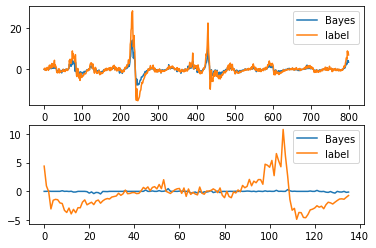

In [103]:


# Seasonality
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import BayesianRidge

x_train = city_data[[col for col in city_data.columns if col not in ['total_cases','total_cases_LOG','pos_neg','diff']]]
y_train = city_data['diff']

# x_train['poly_features'] = np.exp(model.best_estimator_.predict(x_train))

i_test = 800
x_test = x_train.iloc[i_test:]
y_test = y_train[i_test:]


x_train = x_train.iloc[:i_test]
y_train = y_train[:i_test]

splitter = TimeSeriesSplit(5)

clf = KernelRidge()
param_grid = {
                'kernel': ['rbf','poly'],
                'coef0':  [0, 1.0, 2.0],
                'degree': [ 3, 4],    
                'alpha':      [1], #[1, .1, .01, .001, .0001],  
                'gamma':  [1,.1, .01, .001, .0001,.00001]
             }
model_Bayes_alt = GridSearchCV(clf, 
             param_grid, 
             #scoring='neg_mean_absolute_error',
             n_jobs=-1,
             refit=True, 
             cv=splitter,
             return_train_score=True, 
             verbose = 10)
    
    
model_Bayes_alt.fit(x_train, y_train)
    


plt.subplot(211)
plt.plot(model_Bayes_alt.best_estimator_.predict(x_train),label='Bayes')
plt.plot(y_train,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_train),label='spikes')
plt.legend()
plt.subplot(212)
plt.plot(model_Bayes_alt.best_estimator_.predict(x_test),label='Bayes')
plt.plot(y_test.values,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_test),label='spikes')
plt.legend()
print(model_Bayes_alt.best_params_)
print(model_Bayes_alt.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1007s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 300 tas

{'alpha': 10, 'coef0': 0, 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf'}
-27.94089673953881


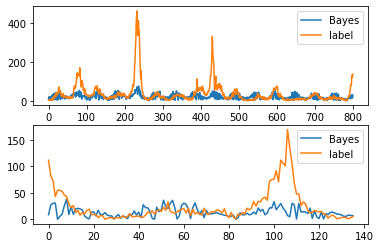

In [104]:


# Seasonality
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import BayesianRidge

x_train = city_data[[col for col in city_data.columns if col not in ['total_cases','total_cases_LOG','pos_neg','diff']]]
y_train = city_data['total_cases']

i_test = 800
x_test = x_train.iloc[i_test:]
y_test = y_train[i_test:]


x_train = x_train.iloc[:i_test]
y_train = y_train[:i_test]

x_train['pos_neg_ALT'] = model_Bayes_alt.predict(x_train)
x_test['pos_neg_ALT'] = model_Bayes_alt.predict(x_test)

splitter = TimeSeriesSplit(5)

clf = KernelRidge()
param_grid = {
                'kernel': ['poly','rbf'],
                'coef0':  [0, 1.0, 2.0],
                'degree': [ 3, 4],    
                'alpha':      [10,1,.1,.01,.001], #[1, .1, .01, .001, .0001],  
                'gamma':  [.1, .01, .001, .0001,.00001]
             }
model_Bayes_posneg = GridSearchCV(clf, 
             param_grid, 
             scoring='neg_mean_absolute_error',
             n_jobs=-1,
             refit=True, 
             cv=splitter,
             return_train_score=True, 
             verbose = 10)
    
    
model_Bayes_posneg.fit(x_train, y_train)
    


plt.subplot(211)
plt.plot(model_Bayes_posneg.best_estimator_.predict(x_train),label='Bayes')
plt.plot(y_train,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_train),label='spikes')
plt.legend()
plt.subplot(212)
plt.plot(model_Bayes_posneg.best_estimator_.predict(x_test),label='Bayes')
plt.plot(y_test.values,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_test),label='spikes')
plt.legend()
print(model_Bayes_posneg.best_params_)
print(model_Bayes_posneg.best_score_)

# LSTM

In [20]:
def return_batch(x_train_data, y_train_data, batch_size=5, seq_length=10):
#     x_batch = np.zeros([batch_size, seq_length, x_train_data.shape[1]]);
#     y_batch = np.zeros([batch_size, 1]);
    
    while True:
        n_batches = int(np.ceil(len(x_train_data)/batch_size));
#         for i_batch in range(n_batches):
        x_batch = []
        y_batch =[]
        c = 0;
        for i in range(len(x_train_data)-seq_length-10):
#             x_batch[c, :,:] = np.expand_dims(x_train_data[i:i+seq_length,:]*1.0, axis=0)
#             y_batch[c,:] = np.expand_dims(y_train[i+seq_length-1]*1.0, axis=0)
            
            x_batch.append(np.expand_dims(x_train_data[i:i+seq_length,:]*1.0,axis=0))
            if len(y_train.shape) == 2:                
                y_batch.append(np.expand_dims(y_train_data.iloc[i+seq_length-1,:].values*1.0, axis=0))
                
            else:
                y_batch.append(np.expand_dims(y_train_data.values[i+seq_length-1]*1.0, axis=0))
                
            c+=1;
            if c%batch_size==0:
                c=0;
                yield np.concatenate(x_batch,axis=0), np.concatenate(y_batch,axis=0)
            
        yield np.concatenate(x_batch,axis=0), np.concatenate(y_batch,axis=0)
                        
# aux, aux2 = return_batch(x_train_set,y_train_set, len(x_train_set))
# aux, aux2 = return_batch(x_val_set, y_val_set,len(x_val_set), l_sequence)



In [ ]:
# Regression
y_train = city_data['total_cases']
from sklearn.model_selection import TimeSeriesSplit

from keras.layers import LSTM, Dense
from keras import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# x_train = city_data[[col for col in city_data.columns if col not in ['total_cases','total_cases_LOG']]]
# y_train = city_data['total_cases']
x_train['spikes']=model_spikes.predict(x_train);
x_test['spikes']=model_spikes.predict(x_test);
x_train['ridge']=model.predict(x_train);
x_test['ridge']=model.predict(x_test);
x_train['ridge_exp']=np.exp(model.predict(x_train));
x_test['ridge_exp']=np.exp(model.predict(x_test));
x_train['bayes']=model_Bayes.predict(x_train);
x_test['bayes']=model_Bayes.predict(x_test);


batch_size = 20;
l_sequence = 50;
n_lstm =  20;
# np.random.seed(15)
x_in = Input(shape=[l_sequence, x_train.shape[1]])
x = LSTM(n_lstm,return_sequences=False, stateful=False)(x_in)
# x = LSTM(1,return_sequences=False, stateful=False)(x)
x = Dense(1,activation='relu')(x)



# model.compile(optimizer='Adam', loss='mae')
opt = Adam(lr=0.01)
model_index = 0;
storage_model = {};

splitter = TimeSeriesSplit(n_splits = 2)
for train_index, val_index in splitter.split(x_train):
#     x_train_set, x_val_set = x_train.iloc[train_index], x_train.iloc[val_index]
#     y_train_set, y_val_set = y_train[train_index], y_train[val_index]
#     print(x_train_set.shape, x_val_set.shape)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
#     x_train_set = scaler.fit_transform(x_train_set)
#     x_val_set = scaler.transform(x_val_set)
    x_train_set = scaler.fit_transform(x_train)
    x_val_set = scaler.transform(x_test)
    y_train_set = y_train;
    y_val_set = y_test;
    
    model_LSTM = Model(inputs = x_in, outputs = x)
#     model.summary()
    model_LSTM.compile(optimizer=opt, loss='mae')
    checkpoint = ModelCheckpoint('models/LSTM_{}'.format(model_index),save_best_only=True)
    h = model_LSTM.fit_generator(return_batch(x_train_set, y_train_set, batch_size,l_sequence),
                        steps_per_epoch = np.round(len(x_train_set)/batch_size),
                        epochs = 300,        
                        verbose=0,
                        validation_data=return_batch(x_val_set, y_val_set,batch_size, l_sequence),
                        validation_steps=np.round(len(x_val_set)/batch_size),
                        callbacks = [checkpoint]
                       )
    aux = {}
    aux['history'] = h;
#     aux['model'] = model;

    #model.save('models/LSTM_{}'.format(model_index))
    aux['scaler'] = scaler
    
    storage_model['model_{}'.format(model_index)] = aux;
    model_index+=1;
    del model_LSTM
#     plt.plot(h.history['loss'], label='train')
#     plt.plot(h.history['val_loss'], label='val')
#     plt.legend()
    break
    

Using TensorFlow backend.


18.71179541321688


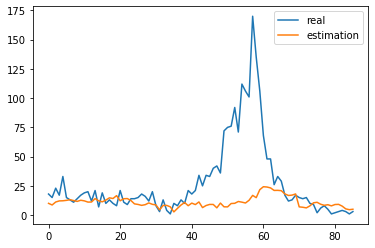

In [43]:
from keras.models import  load_model
for ind_model in range(len(storage_model)):
    model_LSTM = load_model('models/LSTM_{}'.format(ind_model))

    predictions  = []
    real_outputs = []
#     for i in range(len(x_val_set)-l_sequence):
#         predictions.append(np.exp(np.squeeze(model_LSTM.predict(np.expand_dims(x_val_set[i:i+l_sequence,:], axis=0)))));
#         real_outputs.append(np.exp(y_val_set.iloc[i+l_sequence-1]));
    for i in range(len(x_test)-l_sequence):
        #predictions.append((np.squeeze(model_LSTM.predict(np.expand_dims(x_test.iloc[i:i+l_sequence,:], axis=0)))));
        predictions.append((np.squeeze(model_LSTM.predict(np.expand_dims(x_val_set[i:i+l_sequence,:], axis=0)))));
        real_outputs.append((y_test.iloc[i+l_sequence-1]));

    plt.plot(real_outputs, label='real');
    plt.plot(predictions, label='estimation')
    plt.legend()


    from sklearn.metrics import mean_absolute_error
    print(mean_absolute_error(real_outputs, predictions))

{'alpha_1': 1e-09, 'alpha_2': 0.1, 'lambda_1': 0.1, 'lambda_2': 1e-09}
-45.81203231543013


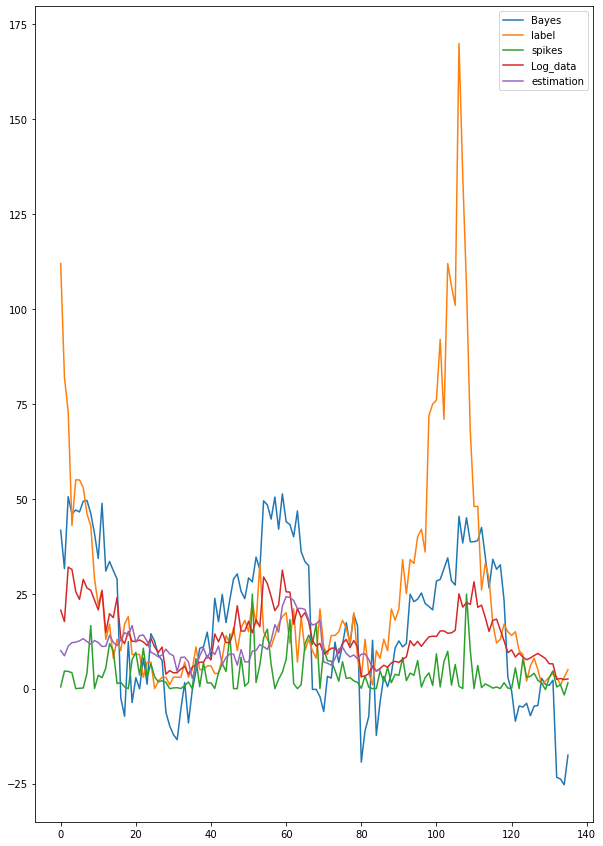

In [46]:
plt.figure(figsize=(10,15))
# plt.subplot(211)
# plt.plot(model_Bayes.best_estimator_.predict(x_train[[i for i in x_train.columns if i != 'extra_data']]),label='Bayes')
# plt.plot(y_train,label='label')
# plt.plot(model_spikes.best_estimator_.predict(x_train[[i for i in x_train.columns if i != 'extra_data']]),label='spikes')
# plt.plot(np.exp(model.best_estimator_.predict(x_train[[i for i in x_train.columns if i != 'extra_data']])), label='Log_data')
# plt.legend()

# plt.subplot(212)
plt.plot(model_Bayes.best_estimator_.predict(x_test[[i for i in x_test.columns if i != 'extra_data']]),label='Bayes')
plt.plot(y_test.values,label='label')
plt.plot(model_spikes.best_estimator_.predict(x_test[[i for i in x_test.columns if i != 'extra_data']]),label='spikes')
plt.plot(np.exp(model.best_estimator_.predict(x_test[[i for i in x_test.columns if i != 'extra_data']])), label='Log_data')
plt.plot(predictions, label='estimation')
plt.legend()
print(model_Bayes.best_params_)
print(model_Bayes.best_score_)

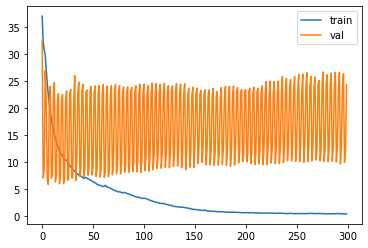

In [38]:
# n_lstm = 5
for n_model in range(len(storage_model)):
    plt.subplot(len(storage_model), 1, n_model+1)
    plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['loss'], label='train')
    plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['val_loss'], label='val')
    plt.legend()

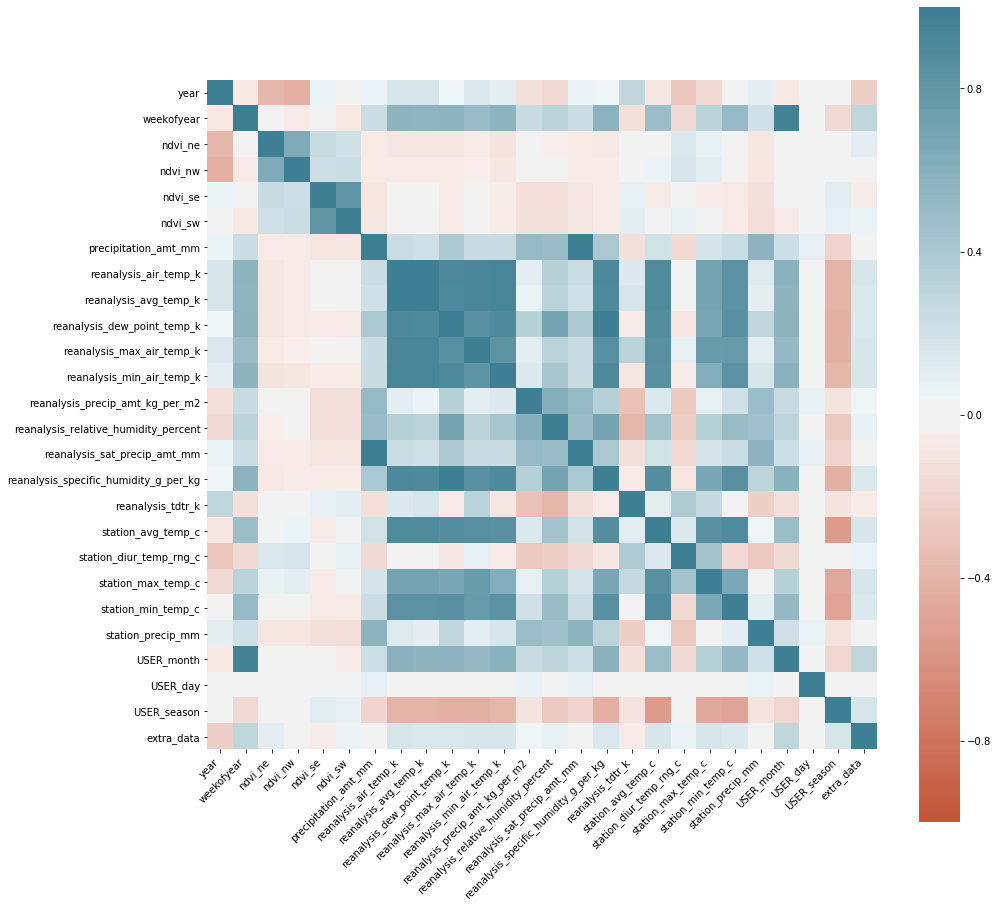

In [39]:
# We study each feature independently and how it relates with the rest
correlation = x_train.corr()
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(15,15)) 
ax = sns.heatmap(
    correlation, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# # Classifier
# y_train = pd.get_dummies(city_data['total_cases_LOG'],prefix=['label'])

# from sklearn.model_selection import TimeSeriesSplit

# from keras.layers import LSTM, Dense
# from keras import Input
# from keras.models import Model
# from keras.optimizers import Adam

# batch_size = 20;
# l_sequence = 20
# n_lstm = 5;
# # np.random.seed(15)
# x_in = Input(shape=[l_sequence, x_train.shape[1]])
# x = LSTM(n_lstm,return_sequences=False, stateful=False)(x_in)
# # x = LSTM(1,return_sequences=False, stateful=False)(x)
# x = Dense(7,activation='sigmoid')(x)



# # model.compile(optimizer='Adam', loss='mae')
# opt = Adam(lr=0.01)
# model_index = 0;
# storage_model = {};

# splitter = TimeSeriesSplit(n_splits = 5)
# for train_index, val_index in splitter.split(x_train):
#     x_train_set, x_val_set = x_train.iloc[train_index], x_train.iloc[val_index]
#     y_train_set, y_val_set = y_train.iloc[train_index], y_train.iloc[val_index]
    
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     x_train_set = scaler.fit_transform(x_train_set)
#     x_val_set = scaler.transform(x_val_set)
    
#     model = Model(inputs = x_in, outputs = x)
#     model.summary()
#     model.compile(optimizer=opt, loss='binary_crossentropy')
#     h = model.fit_generator(return_batch(x_train_set, y_train_set, batch_size,l_sequence),
#                         steps_per_epoch = np.round(len(x_train_set)/batch_size),
#                         epochs = 50,        
#                         verbose=0,
# #                         validation_data=return_batch(x_val_set, y_val_set,batch_size, l_sequence),
# #                         validation_steps=np.round(len(x_val_set)/batch_size)
#                        )
#     aux = {}
#     aux['history'] = h;
#     aux['model'] = model;
#     aux['scaler'] = scaler
    
#     storage_model['model_{}'.format(model_index)] = aux;
#     model_index+=1;
#     del model
# #     plt.plot(h.history['loss'], label='train')
# #     plt.plot(h.history['val_loss'], label='val')
# #     plt.legend()
# #     break
    

In [ ]:
# # n_lstm = 5
# for n_model in range(len(storage_model)):
#     plt.subplot(len(storage_model), 1, n_model+1)
#     plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['loss'], label='train')
#     plt.plot(storage_model['model_{}'.format(n_model)]['history'].history['val_loss'], label='val')
#     plt.legend()

In [ ]:
# from sklearn.metrics import mean_absolute_error
# predictions = []
# real_outputs = []
# for i in val_index:
#     #mean_absolute_error(y_train[np.arange(val_index[0]-batch_size+1,val_index[0]+1)],np.squeeze(model.predict(np.expand_dims(x_train.iloc[np.arange(val_index[0]-batch_size+1,val_index[0]+1)],axis=0))))
# #     print(x_train.iloc[np.arange(i-batch_size+1,i+1)]['year'])

#     y_pred = np.squeeze(model.predict(np.expand_dims(x_train[np.arange(i-batch_size+1,i+1)],axis=0)));
# #     y_pred = np.squeeze(model.predict(np.expand_dims(x_train.iloc[np.arange(i-batch_size+1,i+1)],axis=0)));
#     y_true = y_train[i];
# #     print(y_true)
#     real_outputs.append(y_true)
#     predictions.append(y_pred)
#     print(y_pred, y_true)

# plt.plot(real_outputs, label='real');
# plt.plot(predictions, label='estimation')
# plt.legend()


In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# splitter = TimeSeriesSplit(n_splits = 2)
# n_train = 300;
# x_train_set, x_val_set = x_train.iloc[:n_train], x_train.iloc[n_train-batch_size+1:n_train+1]
# y_train_set, y_val_set = y_train[:n_train], y_train[n_train-batch_size+1:n_train+1]




# opt = Adam(lr = 0.1);

# batch_size = 2;
# x_in = Input(shape=[batch_size, x_train.shape[1]],batch_shape = [1,batch_size, x_train.shape[1]])
# x = LSTM(batch_size,return_sequences=True, stateful=True)(x_in)
# x = LSTM(batch_size,return_sequences=False, stateful=True)(x)

# model = Model(inputs = x_in, outputs = x)
# model.compile(optimizer=opt, loss='mae')
# model.fit_generator(return_batch(x_train_set, y_train_set, batch_size),
#                     steps_per_epoch = np.round(len(x_train_set)/batch_size),
#                     epochs = 5)


In [ ]:
# y_pred = model.predict(np.expand_dims(x_val_set,axis=0))
# mean_absolute_error(y_val_set, np.squeeze(y_pred))

# # model.summary()

# Data scaling

In [ ]:
# from Classifiers import classifiers


In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# aux = scaler.fit_transform(x_train)

In [ ]:
# # Cross-validation
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# import random
# from sklearn.model_selection import RandomizedSearchCV
# n_iter_search = 1000

# clf_list = ['rforest']
# #['knn','SVM_linear','rforest','gboost','SVM','logistic_regression','MLP','adaboost']

# output_classifier = {}
# output_score = {}
# for clf_name in clf_list: 
#     model, param_dist = classifiers(clf_name,1492,n_iter_search)

#     clf = RandomizedSearchCV(model, param_dist, n_iter=10, 
#                        scoring='neg_mean_absolute_error', 
#                              n_jobs=-1, cv=5, verbose=1, random_state=1492)

#     clf.fit(x_train, y_train)
#     output_classifier[clf_name] = clf.best_estimator_
#     output_score[clf_name] = clf.best_score_

In [ ]:
# y_pred = clf.best_estimator_.predict(x_val)

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_val, y_pred)


# Modelling



In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# model = RandomForestRegressor(n_estimators=100)
# model.fit(x_train,y_train)
# y_pred= model.predict(x_train)

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_train, y_pred)

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# model = RandomForestRegressor(n_estimators=100)
# model.fit(aux,y_train)
# y_pred= model.predict(aux)

# from sklearn.metrics import mean_absolute_error
# mean_absolute_error(y_train, y_pred)